In [ ]:
# functions modified from BurnCube

In [1]:
import xarray as xr
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [47]:
#The following file contains cloud free reflectances data from DEA for a bushfire happened in TAS
ds = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/01_LS_Reflectance_and_Indices/Sumac_Forest_NBAR_masked_ls8.nc')
#convert the data into datacube 
stacked = ds.to_stacked_array("cube",sample_dims=('time', 'y', 'x'))
data = stacked[:,:,:,2:].data # in the order of 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'

## Calculation of geometric median  and cosine and euclidian distances

`geometric_median` calculate the geomatric median of band reflectances for the reflectance datacube provided as  (Roberts *et al.*, 2017):

$\hat{m}: = argmin\sum_{i=1}^{n}\parallel x-x_i\parallel_2$, $x\in \mathbb{R}^p$


`cosdistance` is the __cosine distance__ between two spectra, _x_ and _y_, _i.e._, the reflectance time series data and the geometric median reflectance :

$cosdist = 1-\frac{\sum_{i=1}^{p}x_iy_i}{\sqrt{\sum_{i=1}^{p}x_i^2\sum_{i=1}^{p}y_i^2}}$

where _p_ is the number of bands. The denominator is equivalent to the 'spectral angle'.

The Normalized Burn Ratio (NBR) is recommended for use in conjunction with the cosine distance to correctly identify significant reflectance changes that can be associated with fire events. 
NBR is calculated as:

$NBR = \frac{nir-swir2}{nir+swir2}$

`nbr_eucdistance` is the __Euclidean distance in NBR space__ between the NBR time series and the median NBR (_NBRmed_) calculated from the geometric median:

$NBRdist = \sqrt{\sum_{i=1}^{n}(NBR_i-NBRmed)^2}$

In [69]:
# core functions for burnmapping 
def geometric_median(x, epsilon=1, max_iter=40):
    """
    Calculates the geometric median of band reflectances
    The procedure stops when either the error tolerance 'tol' or the maximum number of iterations 'MaxIter' is reached. 
    Args:
        x: (p x N) matrix, where p = number of bands and N = number of dates during the period of interest
        max_iter: maximum number of iterations
        tol: tolerance criterion to stop iteration   
    
    Returns:
        geo_median: p-dimensional vector with geometric median reflectances
    """
    y0 = np.nanmean(x, axis=1)
    if len(y0[np.isnan(y0)]) > 0:
        return y0

    for _ in range(max_iter):
        euc_dist = np.transpose(np.transpose(x) - y0)
        euc_norm = np.sqrt(np.sum(euc_dist ** 2, axis=0))
        not_nan = np.where(~np.isnan(euc_norm))[0]
        y1 = np.sum(x[:, not_nan] / euc_norm[not_nan], axis=1) / (np.sum(1 / euc_norm[not_nan]))
        if len(y1[np.isnan(y1)]) > 0 or np.sqrt(np.sum((y1 - y0) ** 2)) < epsilon:
            return y1

        y0 = y1

    return y0

def cos_distance(ref, obs):
    """
    Returns the cosine distance between observation and reference
    The calculation is point based, easily adaptable to any dimension. 
    Args:
        ref: reference (1-D array with multiple bands) e.g., geomatrix median [Nbands]
        obs: observation (with multiple bands, e.g. 6) e.g.,  monthly geomatrix median or reflectance [Nbands,ndays]
    
    Returns:
        cosdist: the cosine distance at each time step in [ndays]
    """
    ref = ref.astype(np.float32)[:, np.newaxis]
    obs = obs.astype(np.float32)
    cosdist = np.empty((obs.shape[1],))
    cosdist.fill(np.nan)
    #index = np.where(~np.isnan(obs[0, :]))[0]
    #cosdist[index] = np.transpose(
    #    [1 - np.sum(ref[:,0] * obs[:, t]) / (np.sqrt(np.sum(ref[:,0] ** 2)) * np.sqrt(np.sum(obs[:, t] ** 2))) for t in index])
    cosdist = np.transpose((1-np.nansum(ref*obs,axis=0)/np.sqrt(np.sum(ref ** 2)) / np.sqrt(np.nansum(obs ** 2,axis=0))))
    return cosdist


def nbr_eucdistance(ref, obs):
    """
    Returns the euclidean distance between the NBR at each time step with the NBR calculated from the geometric medians
    and also the direction of change to the NBR from the geometric medians.
    
    Args:
        ref: NBR calculated from geometric median, one value
        obs: NBR time series, 1-D time series array with ndays 
    
    Returns:
        nbr_dist: the euclidean distance 
        
    """
    nbr_dist = np.empty((obs.shape[0],))
    nbr_dist.fill(np.nan)
    index = np.where(~np.isnan(obs))[0]
    euc_dist = (obs[index] - ref)
    euc_norm = np.sqrt((euc_dist ** 2))
    nbr_dist[index] = euc_norm
    
    return nbr_dist


In [70]:
Nbands = 6
GeoMed= np.empty((Nbands,len(ds.y),len(ds.x)))
GeoMed.fill(np.nan)
CosDist= np.empty((len(ds.time),len(ds.y),len(ds.x)))
CosDist.fill(np.nan)
#calculating NBR
NBR = (ds.nir.data-ds.swir2)/(ds.nir.data+ds.swir2)
GeoMedNBR = np.empty((len(ds.y),len(ds.x)))*np.nan
NbrDist = np.empty((len(ds.time),len(ds.y),len(ds.x)))
NbrDist.fill(np.nan)
for y in range(0,len(ds.y)):
    for x in range(0,len(ds.x)):
        GeoMed[:,y,x] = geometric_median(data[:,y,x,:].T)
        CosDist[:,y,x] = cos_distance(GeoMed[:,y,x], data[:,y,x,:].T)
        GeoMedNBR[y,x] = (GeoMed[3,y,x]-GeoMed[5,y,x])/(GeoMed[3,y,x]+GeoMed[5,y,x])
        NbrDist[:,y,x] = nbr_eucdistance(GeoMedNBR[y,x], NBR[:,y,x])

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [88]:
def severitymapping(CDist, NDist, Time):
    #calculate the outliers as ( 75th percentile + 1.5*IQR) for each location and output as 2D array [y,x]
    CDistoutlier = np.nanpercentile(CDist,75,axis=0)+1.5*(np.nanpercentile(CDist,75,axis=0)-np.nanpercentile(CDist,25,axis=0))
    NDistoutlier = np.nanpercentile(NDist,75,axis=0)+1.5*(np.nanpercentile(NDist,75,axis=0)-np.nanpercentile(NDist,25,axis=0))    
    sevindex = np.zeros(((CDist.shape[1]),(CDist.shape[2]))) 
    duration = np.zeros(((CDist.shape[1]),(CDist.shape[2])))
    startdate = np.empty(((CDist.shape[1]),(CDist.shape[2])))*np.nan

    for x in range(0,(CDist.shape[2])):
        for y in range(0,(CDist.shape[1])):                
            notnanind = np.where(~np.isnan(CDist[:,y,x]))[0] #remove the nan values for each pixel
            cosdist = CDist[notnanind,y,x]
            nbrdist = NDist[notnanind,y,x]
            outlierind = np.where((cosdist>CDistoutlier[y,x])*(nbrdist>NDistoutlier[y,x]))[0]
            time = Time[notnanind]
            outlierdates = time[outlierind]
            AreaAboveD0 = 0
            if len(outlierind)>=2:
                tt = []            
                for ii in range(0,len(outlierind)):
                    if outlierind[ii]+1<len(time):
                        u = np.where(time[outlierind[ii]+1]==outlierdates)[0] 
                        if len(u)>0:
                            t1_t0 = (time[outlierind[ii]+1]-time[outlierind[ii]])/np.timedelta64(1, 's')/(60*60*24)
                            y1_y0 = (cosdist[outlierind[ii]+1] +cosdist[outlierind[ii]] )-2*CDistoutlier[y,x]
                            AreaAboveD0 = AreaAboveD0 + 0.5*y1_y0*t1_t0                                                         
                            duration[y,x] = duration[y,x] + t1_t0
                            tt.append(ii) # record the index where it is detected as a change

                if len(tt)>0:                
                    startdate[y,x] = time[outlierind[tt[0]]] #record the date of the first change 
                    sevindex[y,x] = AreaAboveD0

    return sevindex,startdate,duration

In [89]:
#severity mapping
sevindex,startdate,duration = severitymapping(CosDist,NbrDist,ds.time)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Text(0.5, 1.0, 'Duration')

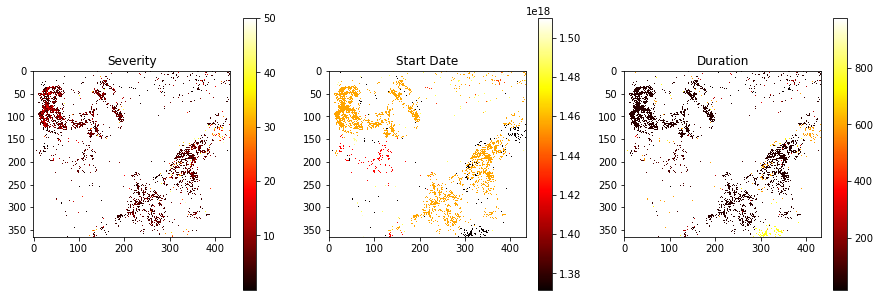

In [93]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sevindex[sevindex==0] = np.nan
plt.imshow(sevindex,vmax = 50, cmap = 'hot')
plt.colorbar()
plt.title('Severity')

plt.subplot(132)
plt.imshow(startdate, cmap = 'hot')
plt.colorbar()
plt.title('Start Date')

plt.subplot(133)
duration[duration==0] = np.nan
plt.imshow(duration, cmap = 'hot')
plt.colorbar()
plt.title('Duration')

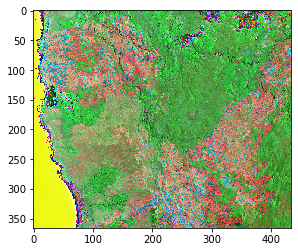

In [51]:
def stretch_RGB(data,minimum,maximum):
    
    tmp = data
    #a = (tmp-np.percentile(tmp,3))/(np.percentile(tmp,97)-np.percentile(tmp,3))*255
    img = (tmp-minimum)/(maximum-minimum)*255    
    return img
from PIL import Image,ImageEnhance
#plot the geometric median with swir2,nir and green band as R,G,B
rgbArray = np.zeros((GeoMed.shape[1],GeoMed.shape[2],3), 'uint8')
rgbArray[..., 0] = (stretch_RGB(GeoMed[5,:,:],100,900))
rgbArray[..., 1] = (stretch_RGB(GeoMed[3,:,:],150,3000))
rgbArray[..., 2] = (stretch_RGB(GeoMed[1,:,:],100,600))
img = Image.fromarray(rgbArray)
plt.imshow(img)